# Assignment 7 - Graph drawing and network analysis

An important step to gain insight from data is to recognize existing, known structure and incorporate it into your analysis.
Graph structures as a mathematical representation of connectedness can be found in a wide variety of practical settings.

In this assignment we hope to enable you to:

* Understand what graphs are and how to recognize graph-type relationships in your data
* Use standard graph analysis techniques and tools to get answers for data analysis questions
* Work with large graphs on a desktop machine using the [graph-tool python library](https://graph-tool.skewed.de/)

## Background on graphs and a tool tutorial

If you require an introduction to basic graph notions, see [Maël Fabien
's blog post](https://towardsdatascience.com/introduction-to-graphs-part-1-2de6cda8c5a5) sections I and II.
While graph theory and algorithms can involve deep mathematical connections, 
the basic definitions and much practical use of graph data is not difficult to get started with.

For further background on `graph-tool` refer to the [graph tutorial slides](https://stevenbergner.github.io/Teaching/cmpt767/graph-tutorial) and the [tutorial notebook](graph-tool-tutorial.ipynb).
See the [lab setup](#Environment-setup-details) on how you can use graph tool on the lab machines.

In [1]:
# Use this code for basic setup

import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown
%matplotlib inline

import graph_tool.all as gt
print("graph-tool version: {}".format(gt.__version__.split(' ')[0]))

import gt_utils as au

graph-tool version: 2.46


# Problem 1: Power grid analysis

In [2]:
g = gt.collection.data['power']
display(Markdown(gt.collection.descriptions['power']))

Power grid: An undirected, unweighted network representing the topology of the Western States Power Grid of the United States. Data compiled by D. Watts and S. Strogatz and made available on the web `here <http://cdg.columbia.edu/cdg/datasets>`_. Please cite D. J. Watts and S. H. Strogatz, Nature 393, 440-442 (1998). Retrieved from `Mark Newman's website <http://www-personal.umich.edu/~mejn/netdata/>`_.

 In this graph, an edge represents a power supply line. A node is either a generator, a transformator, or a substation.
 
**Task 1a**: Create a drawing of this graph that emphasizes nodes that have more than 10 incident (or incoming) power supply lines. Set the size of all other nodes to 0, but retain visibility of the power lines.

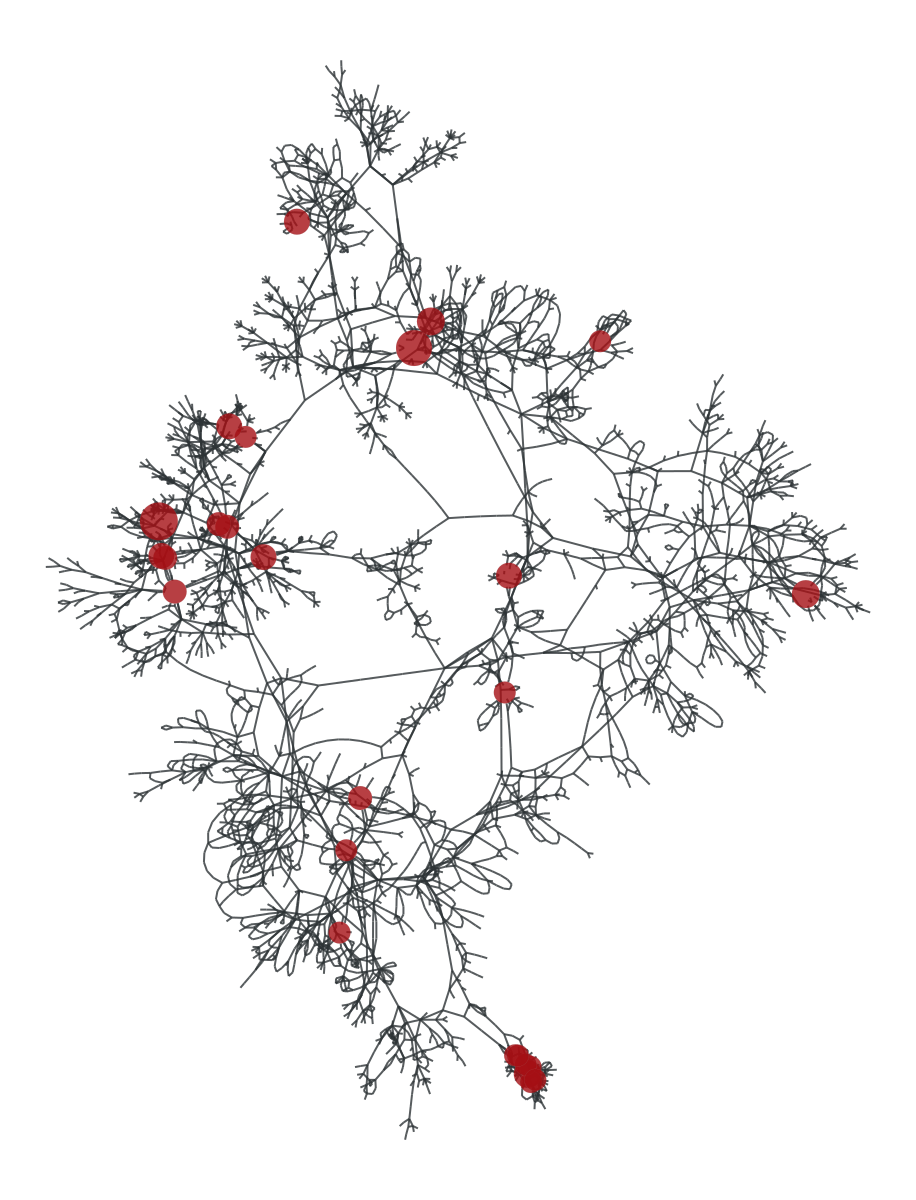

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1978484d0, at 0x17e691f50>

In [3]:
# TODO
# Create a new vertex property map to store the number of power supply lines for each vertex
power_supply_count = g.new_vertex_property('int')

# Loop through each vertex in the graph
for vertex in g.vertices():
    # Check if the vertex has more than 10 outgoing power supply lines
    if vertex.out_degree() > 10:
        # Store the count of power supply lines in the power_supply_count property map for that vertex
        power_supply_count[vertex] = vertex.out_degree()

# Draw the graph with the vertex size proportional to the number of power supply lines
gt.graph_draw(g, vertex_size=power_supply_count, edge_pen_width=1)

**Task 1b:** Identify one of the centrality measures that can be used to indicate powerlines that act as a bridge between different parts of the network. Use this to emphasize structurally important nodes and powerlines.

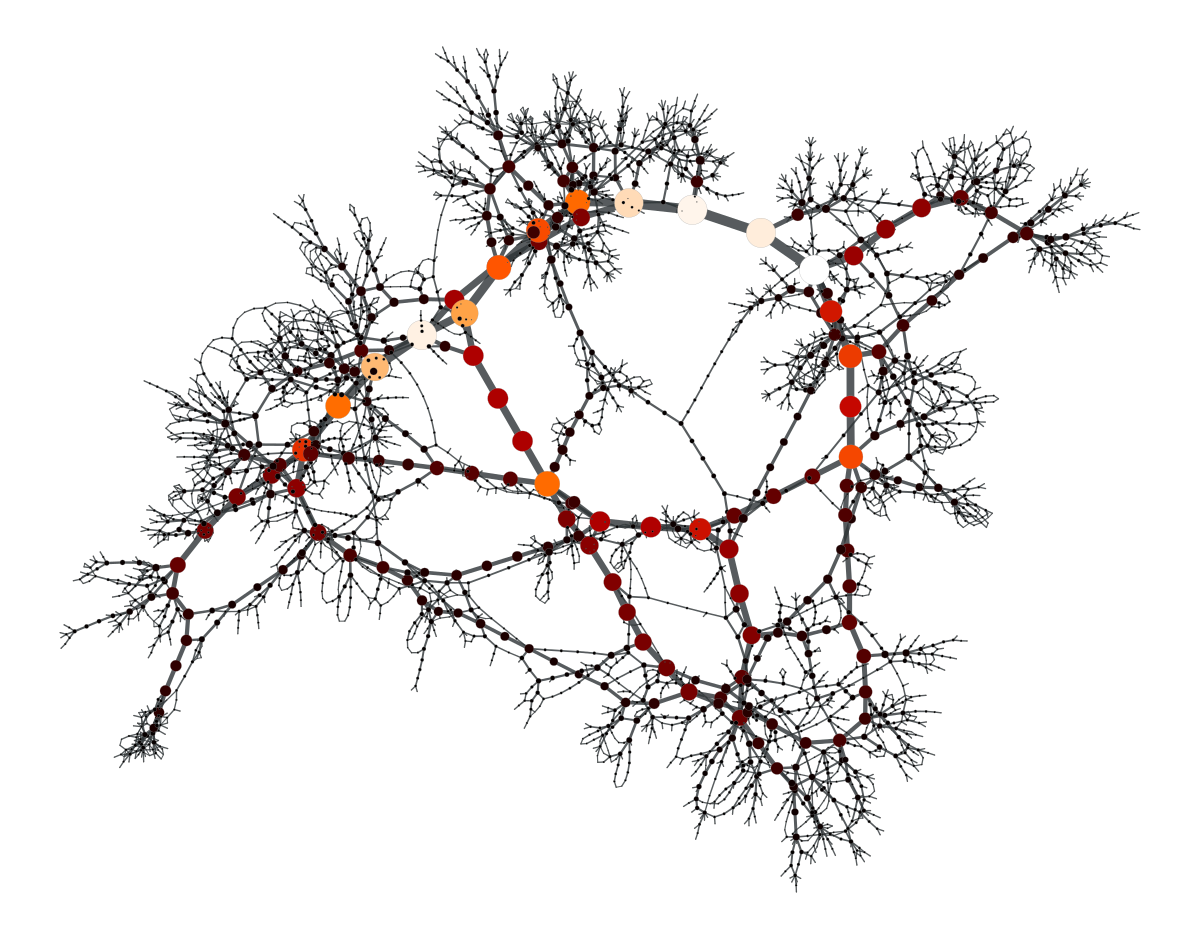

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1978484d0, at 0x1113c5c50>

In [4]:
# TODO
# Calculate the betweenness centrality of the vertices and edges
vertex_betweenness, edge_betweenness = gt.betweenness(g)

# Set the positions of the vertices based on their coordinates
pos = g.vp["pos"]

# Draw the graph with vertex color, size, and edge width based on betweenness centrality
gt.graph_draw(g, pos=pos, vertex_fill_color=vertex_betweenness,
               vertex_size=gt.prop_to_size(vertex_betweenness, mi=0.5, ma=15),
               edge_pen_width=gt.prop_to_size(edge_betweenness, mi=0.5, ma=5),
               vcmap=mpl.cm.gist_heat
             )

# Problem 2: Small social graph visualization

In [5]:
X_knows = {
    'Mary': ['Peter', 'Albert', 'DavidF', 'Peter'],
    'Judy': ['Bob', 'Alan'],
    'Peter': ['Mary', 'DavidF', 'Jon'],
    'DavidF': ['Albert', 'Joseph', 'Peter', 'Mary'],
    'Jon': ['Peter', 'Joseph', 'DavidE'],
    'DavidE': ['Jon', 'Joseph', 'Albert'],
    'Joseph': ['DavidE', 'Jon', 'DavidF'],
    'Bob': ['Judy', 'Alan'],
    'Alan': ['Bob', 'Mary', 'Judy'],
    'Albert': ['DavidF', 'Mary', 'DavidE'],
}

**Task**: Create an undirected graph that represents the personal network above, remove parallel edges, and draw using a layout that resembles the tidy example as shown further below.

In [11]:
edges_set = set()
for person, connections in X_knows.items():
    for connection in connections:
        edge = (person, connection)
        reverse_edge = (connection, person)
        if edge not in edges_set and reverse_edge not in edges_set:
            edges_set.add(edge)

g = gt.Graph(directed=False)
v_name = g.add_edge_list(edges_set, hashed=True)
g.vertex_properties['name'] = v_name

pos = gt.random_layout(g)
au.rotate_layout(pos, "Alan", "Mary", v_name)

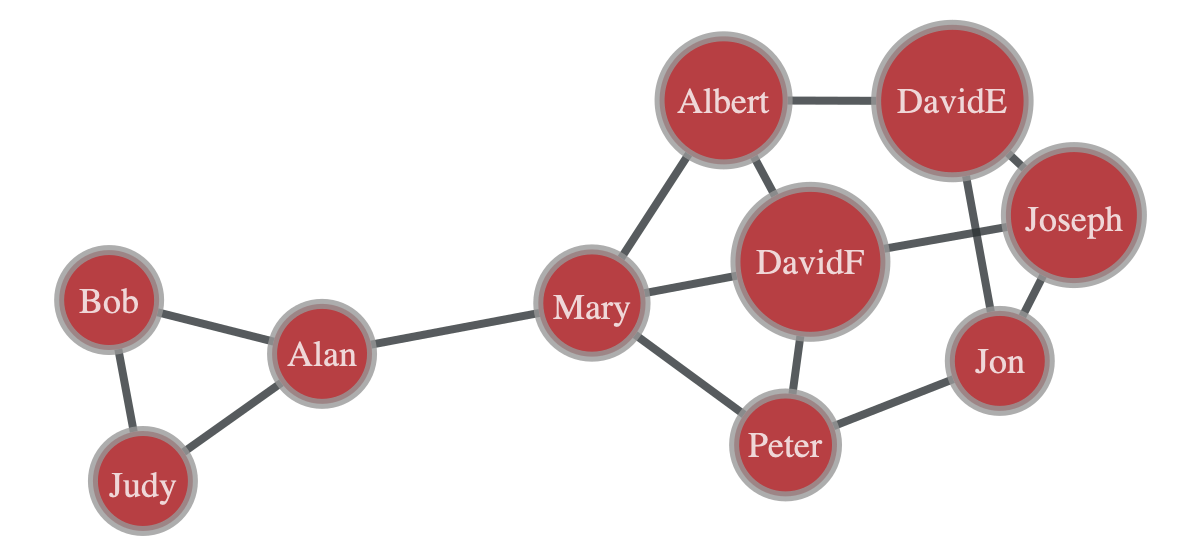

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1c0ac80d0, at 0x1c127fb10>

In [19]:
gt.graph_draw(g,
              vertex_text=v_name,
              edge_pen_width = 4, 
              output_size = (600, 400),
              vertex_font_size = 18,
              vertex_size = 50
             )

After adjusting the code above you should be able to obtain a 'tidy' result like this.
![](graph.svg)

# Problem 3: Facebook graph analysis

For this question we will work with a real social graph of facebook friendship connections. Please download [`facebook_combined.txt` from SNAP](https://snap.stanford.edu/data/ego-Facebook.html), the Stanford Large Network Dataset Collection and create a `Graph` object with `graph-tool`. The dataset contains the ego networks of 10 facebook users, i.e. it contains the ego nodes, the friends of each of these facebook users, and the connections among those friends.

Goal below is to determine influencers among the users, based on a measure of centrality and not including the ego nodes themselves.

**Task 3a:** Load the dataset and create a drawing of the graph.

In [21]:
# TODO
facebook_graph = gt.load_graph_from_csv('facebook_combined.txt',csv_options={'delimiter': ' '})

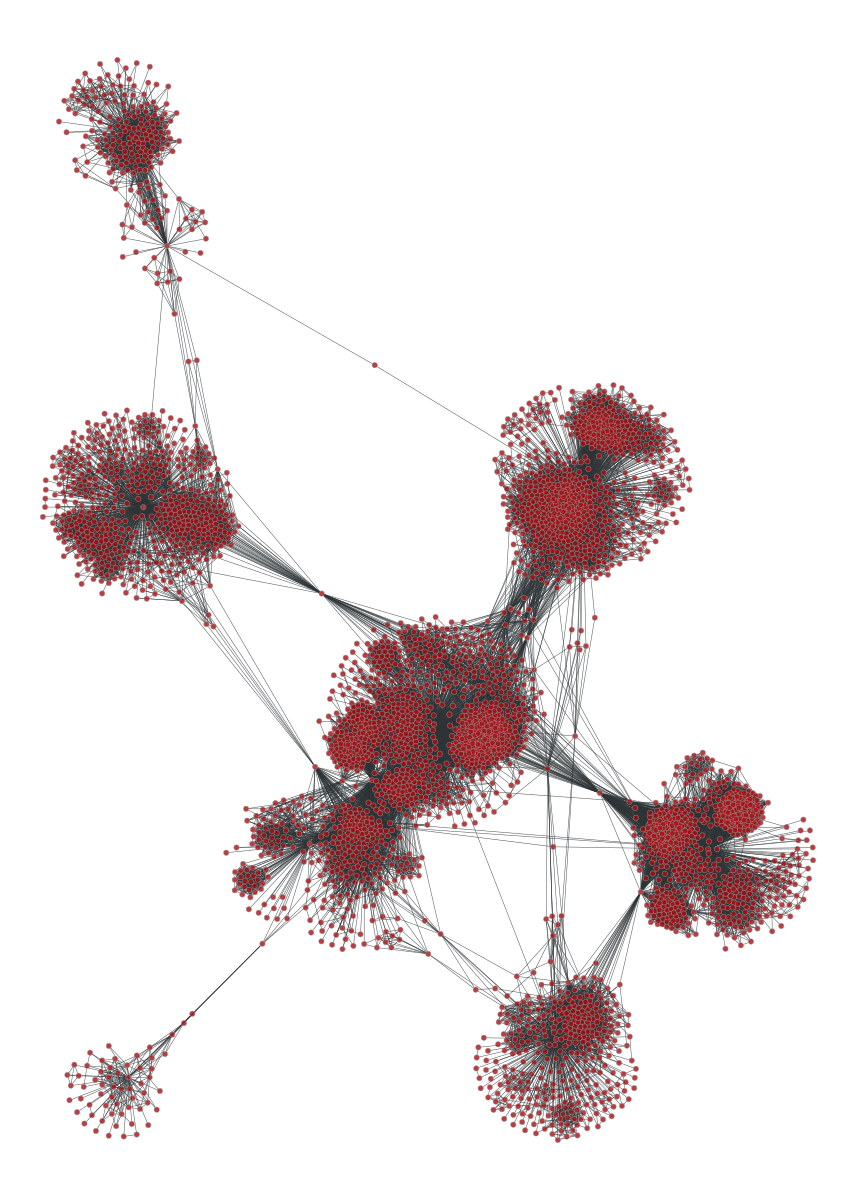

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1be6e4150, at 0x1c0ae8e10>

In [22]:
# TODO
gt.graph_draw(facebook_graph)

**Task 3b:** Calculate and show a histogram of pairwise distances among users. Internally, this distance would be computed for the shortest path of connections among any pair of users.

Use a log-scale of the frequencies to scale the histogram bars.

What is the diameter of this graph?

*Hint:* Calculating and drawing the histograms amounts to two lines of code using `gt` and `plt` modules.

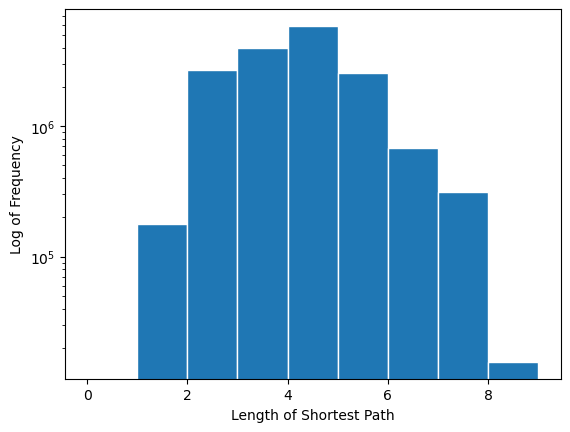

In [34]:

histogram_counts, histogram_bins = gt.distance_histogram(facebook_graph)

plt.hist(histogram_bins[:-1], bins=histogram_bins, edgecolor = 'white', weights=histogram_counts, log=True)
plt.xlabel('Length of Shortest Path')
plt.ylabel('Log of Frequency')
plt.show()

**Task 3c:** Determine influencers, i.e. people withing the ego network that are well connected among friends.

There are several steps to this analysis. First, remove the ego nodes. You can do this in an approximate way, simply by calculating a measure of influence of a user and removing the highest scoring nodes, assuming that these naturally are the ego nodes whose friends this network consists of.

Use `PageRank` as a measure of influence of a node.

*Step 1* - Create a drawing of a GraphView that only retains nodes with a `pagerank` $< 0.002$.

In [36]:
# TODO
pageRank = gt.pagerank(facebook_graph)
facebook_graph.vp['rank'] = pageRank
g = gt.GraphView(facebook_graph, vfilt=facebook_graph.vp['rank'].a < 0.002)

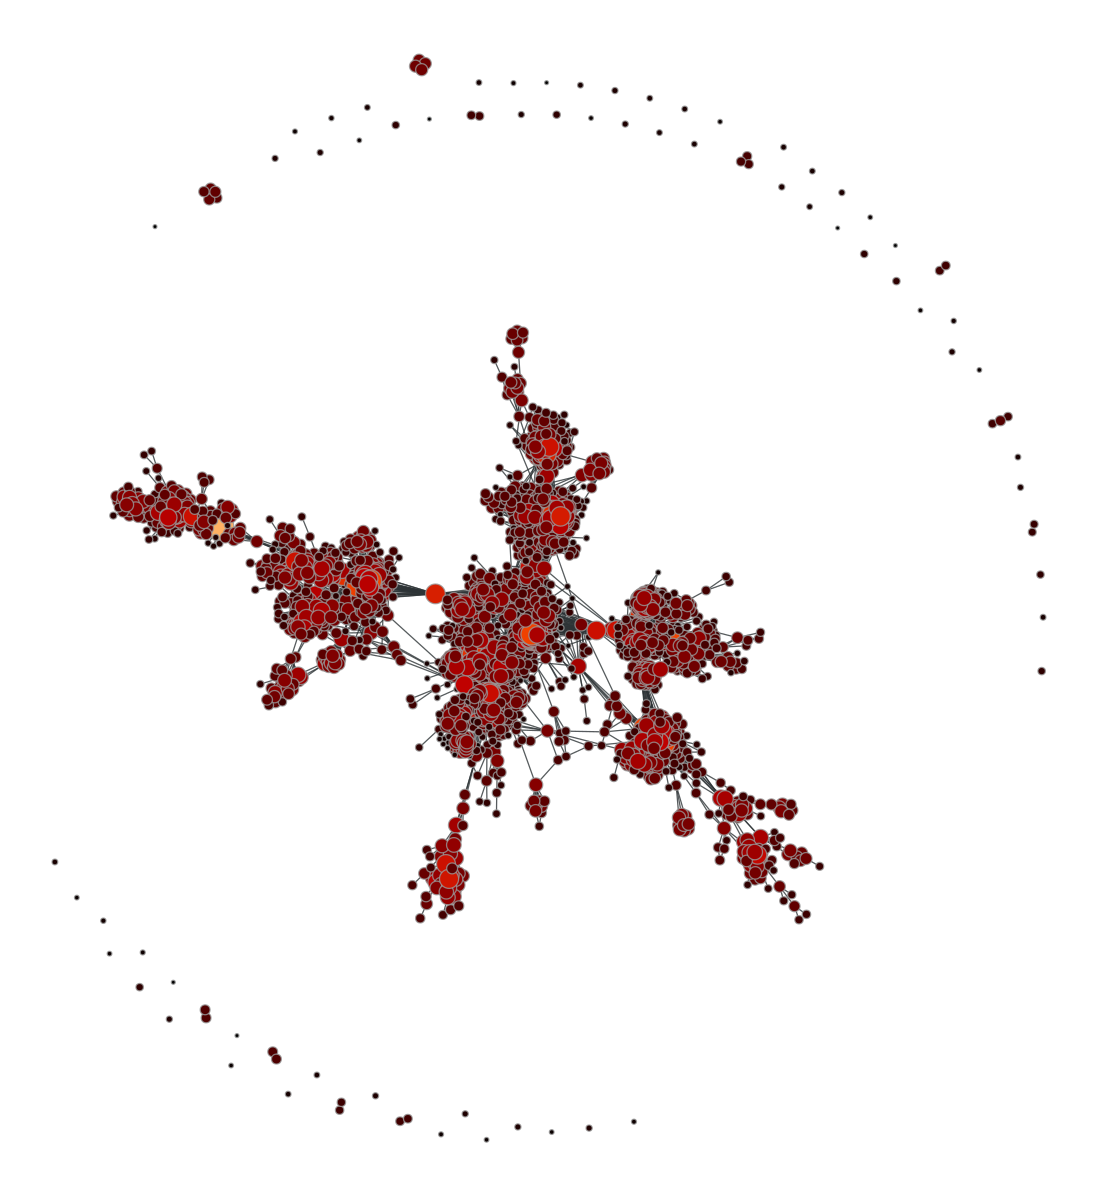

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1c8b316d0, at 0x1c2d12dd0>

In [37]:
# TODO
gt.graph_draw(g, 
              output_size = (600, 600),
              vcmap = mpl.cm.gist_heat,             
              vertex_size = gt.prop_to_size(g.vp['rank'], 2, 16),
              vertex_fill_color = gt.prop_to_size(g.vp['rank'], 0, 12))

*Step 2* - Only retain the largest connected component of this graph, i.e. create another [`GraphView`](https://graph-tool.skewed.de/static/doc/quickstart.html#graph-views) of only this largest component.

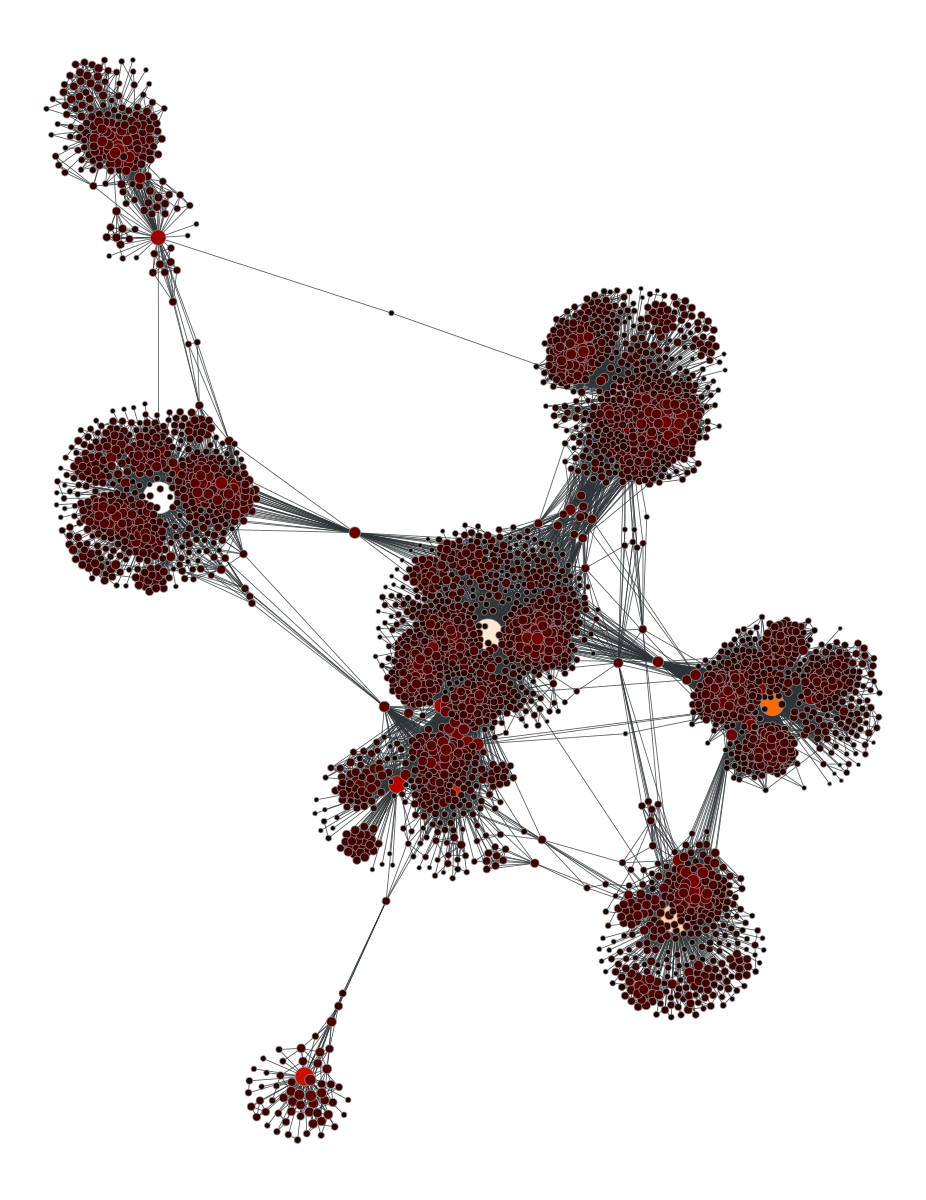

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1c2613a90, at 0x1c2d47190>

In [39]:
#### TODO
largest_component = gt.extract_largest_component(facebook_graph)

g = gt.GraphView(largest_component)

vertex_size = gt.prop_to_size(g.vp['rank'], 2, 16)
vertex_fill_color = gt.prop_to_size(g.vp['rank'], 0, 12)

gt.graph_draw(g, output_size=(600, 600), vcmap=plt.cm.gist_heat,
              vertex_size=vertex_size, vertex_fill_color=vertex_fill_color)

*Step 3* - Recalculate pagerank for each node, choose a threshold (e.g. 0.0005) above which only a small part of the users are selected. Create a drawing that emphasizes these users that play central roles among their friends.

In [41]:
# TODO
page_rank = gt.pagerank(facebook_graph)

for i in range(len(page_rank.a)):
    if page_rank.a[i] <= 0.0005:
        page_rank.a[i] = 0


facebook_graph.vp['new_rank'] = page_rank

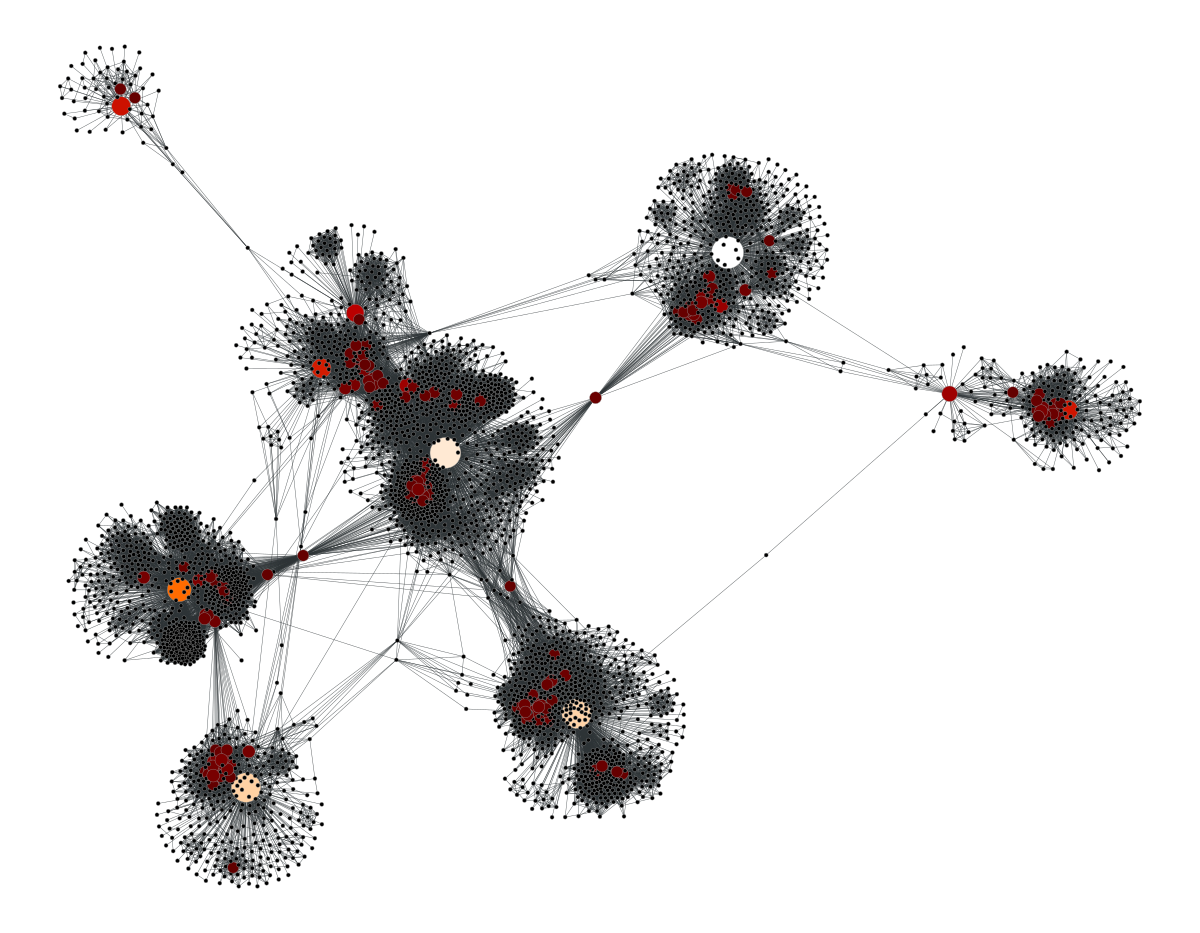

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1c2ba46d0, at 0x1c8b1cf50>

In [42]:
# TODO
largestConnected = gt.extract_largest_component(facebook_graph)

g = gt.GraphView(largestConnected)


vertex_size = gt.prop_to_size(g.vp['new_rank'], 2, 16)
vertex_fill_color = gt.prop_to_size(g.vp['new_rank'], 0, 12)

gt.graph_draw(g, output_size=(600, 600), vcmap=plt.cm.gist_heat,
              vertex_size=vertex_size, vertex_fill_color=vertex_fill_color)


# Environment setup details

[Setup instruction](https://git.skewed.de/count0/graph-tool/-/wikis/installation-instructions#installation-via-package-managers) are available for most environments. To use the setup in the lab, see below.

We have prepared a `conda` environment in the lab that contains all modules required for this assignment. You can activate the environment as follows:

```
conda activate /usr/shared/CMPT/big-data/condaenv/gt
```

#### You might get an error
`CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.`
This happens, if you have not used conda before. To perform initialization once, we recommend the following steps:
```
conda init bash
conda config --set auto_activate_base false
```
If you now restart your terminal shell or simply invoke a new one by typing `bash`, you can try activating the environment, again.

# Submission instructions
Please submit [this notebook](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A7/A7.ipynb) 
to [CourSys](https://coursys.sfu.ca/2023sp-cmpt-733-g1/+a7/),
filled out with figures included.